In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
def create_blr_problem(dim, seed):
    if dim in [2, 5]:
        prior_alpha = 1
        signal_std = 5e-3
    else:
        prior_alpha = 1
        signal_std = 1e-1
    torch.set_default_tensor_type(torch.DoubleTensor)
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=prior_alpha,
                            signal_std=signal_std,
                            num_targets=20,
                            seed=seed,
                            num_train_points=3)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [8]:
def compute_preds(d, blr_obj, training_data=False):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [177]:
def true_preds(blr_obj, training_data=False, seed=1):
    torch.manual_seed(seed)
    samples = blr_obj.weight_posterior.sample((10000,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [178]:
def var_approx_preds(blr_obj, training_data=False, seed=1):
    torch.manual_seed(seed)
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((10000,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [179]:
def compute_preds_from_samples(samples, blr_obj, xs):
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, feature_targets=xs.reshape(-1, 1))[None]))
    return preds

In [180]:
def compute_log_prob_empirical_mog(full_preds, blr):
    normal_dists = dist.normal.Normal(loc=full_preds, scale = signal_std)
    log_probs = normal_dists.log_prob(blr.regression_targets_test)
    sum_of_probs = torch.logsumexp(log_probs, dim=1)
    normalisation_constant = torch.log(torch.tensor(full_preds.shape[1]))
    gmm_log_prob_per_point = sum_of_probs - normalisation_constant
    gmm_log_prob = torch.sum(gmm_log_prob_per_point, dim=1)
    return gmm_log_prob

In [181]:
def make_gmm(preds, signal_std):
    mix = dist.Categorical(torch.ones((preds.shape[1],)))
    comp = dist.Independent(dist.Normal(loc=preds, scale=signal_std), 1)
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm

In [182]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

# Ensemble LL

## Test set

In [183]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 2
beamwidth = 5
emp = []
vari = []
hard = False
for eps in epsilons:
    vari.append(pkl.load(open(f"PickledStuff/BLR_RESULTS/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    emp.append(pkl.load(open(f"PickledStuff/BLR_RESULTS/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))

In [184]:
blr_seed = 1
b, t = create_blr_problem(dim=dim, seed=blr_seed)

In [185]:
emp_kl = dist.kl_divergence(t, b.weight_prior)

In [186]:
var_kl = dist.kl_divergence(compute_variational_posterior(t), b.weight_prior)

In [187]:
exact_log_probs = make_gmm(true_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [188]:
exact_var_log_probs = make_gmm(var_approx_preds(b)[None], signal_std=b.signal_std).log_prob(b.regression_targets_test)

In [189]:
vari_full_preds = torch.zeros(len(epsilons), 500, len(b.regression_targets_test))
emp_full_preds = torch.zeros(len(epsilons), 500, len(b.regression_targets_test))
for i, _ in enumerate(epsilons):
    emp_full_preds[i] = compute_preds(emp[i], b)
    vari_full_preds[i] = compute_preds(vari[i], b)

In [190]:
var_gmm = make_gmm(vari_full_preds, signal_std=b.signal_std)
var_log_probs = var_gmm.log_prob(b.regression_targets_test)

In [191]:
emp_gmm = make_gmm(emp_full_preds, signal_std=b.signal_std)
emp_log_probs = emp_gmm.log_prob(b.regression_targets_test)

In [192]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=b.signal_std).log_prob(b.regression_targets_test))

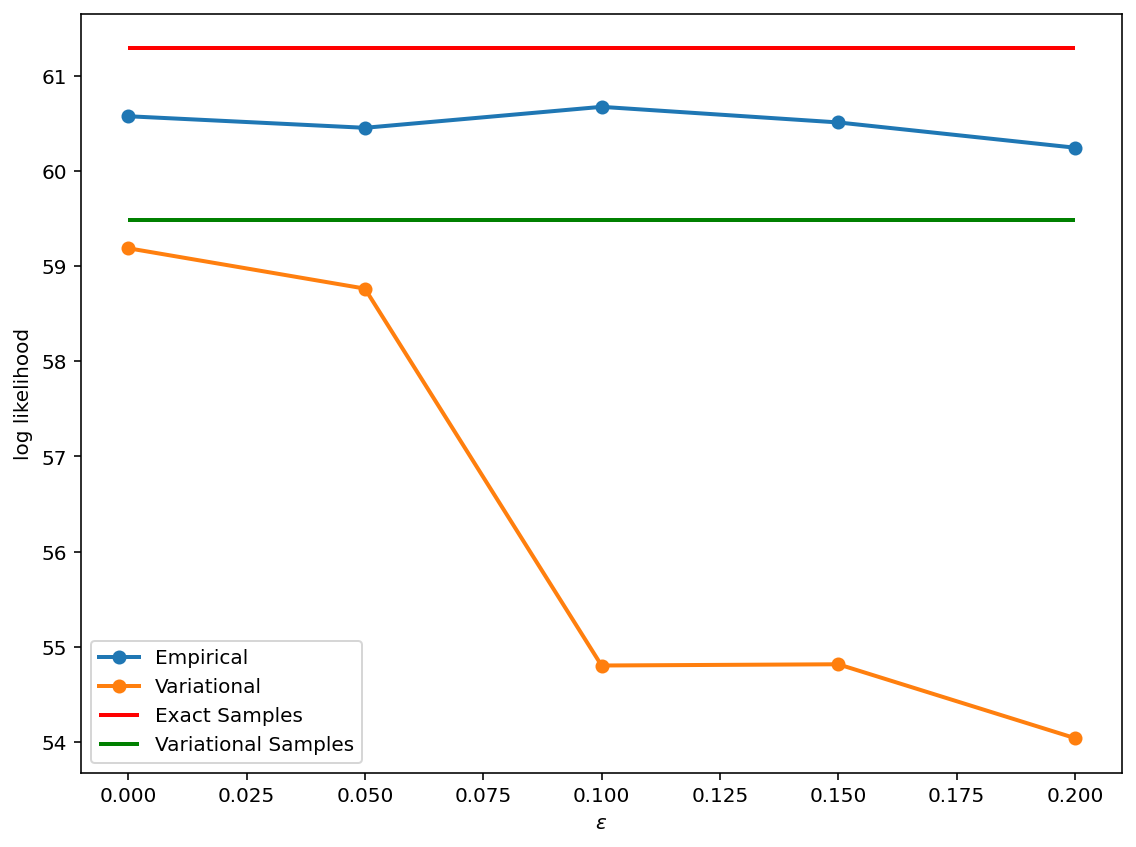

In [193]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs, '-o', label='Empirical')
ax.plot(epsilons, var_log_probs, '-o', label='Variational')
ax.hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

## Training set

In [194]:
exact_log_probs_train = make_gmm(true_preds(b, training_data=True)[None], signal_std=b.signal_std).log_prob(b.regression_targets_train)

In [195]:
exact_var_log_probs_train = make_gmm(var_approx_preds(b, training_data=True)[None], signal_std=b.signal_std).log_prob(b.regression_targets_train)

In [196]:
vari_full_preds_train = torch.zeros(len(epsilons), 500, len(b.regression_targets_train))
emp_full_preds_train = torch.zeros(len(epsilons), 500, len(b.regression_targets_train))
for i, _ in enumerate(epsilons):
    emp_full_preds_train[i] = compute_preds(emp[i], b, training_data=True)
    vari_full_preds_train[i] = compute_preds(vari[i], b,training_data=True)

In [197]:
var_gmm = make_gmm(vari_full_preds_train, signal_std=b.signal_std)
var_log_probs_train = var_gmm.log_prob(b.regression_targets_train)

In [198]:
emp_gmm = make_gmm(emp_full_preds_train, signal_std=b.signal_std)
emp_log_probs_train = emp_gmm.log_prob(b.regression_targets_train)

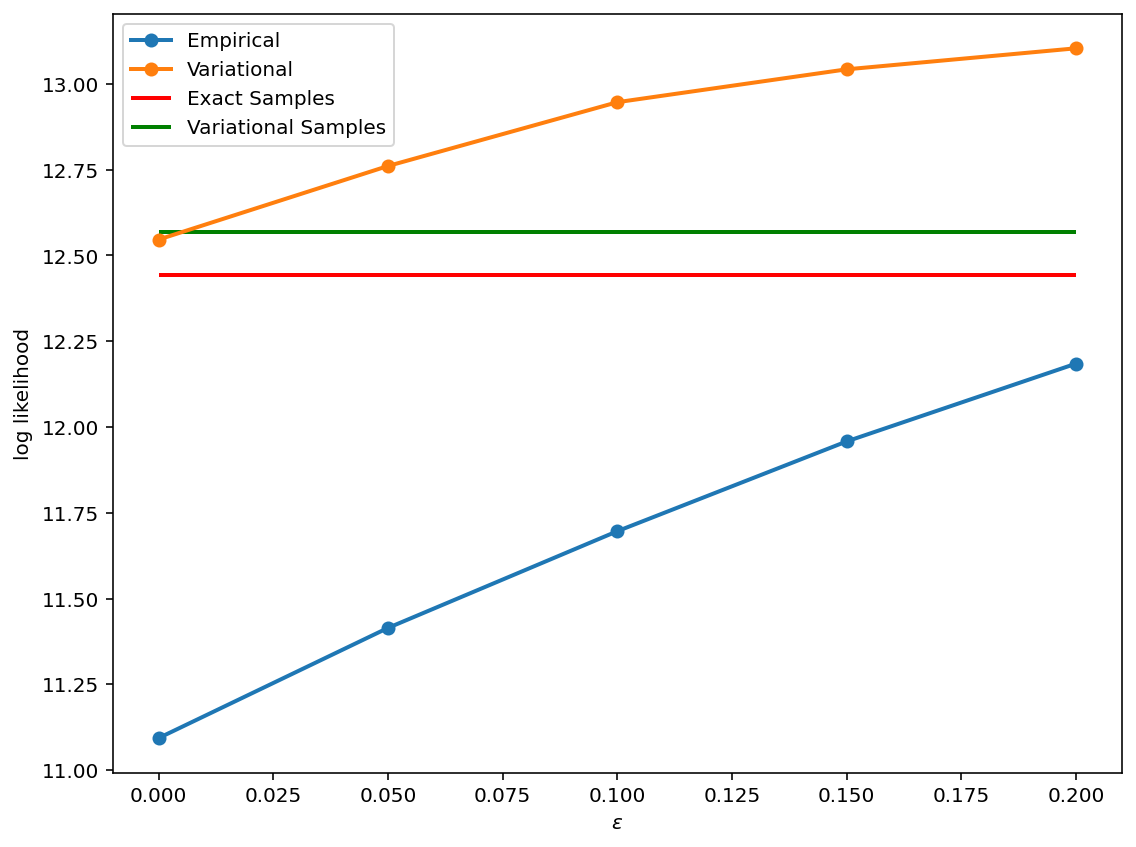

In [199]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(epsilons, emp_log_probs_train, '-o', label='Empirical')
ax.plot(epsilons, var_log_probs_train, '-o', label='Variational')
ax.hlines(exact_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Samples')
ax.hlines(exact_var_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='green', label='Variational Samples')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend()
fig.tight_layout()

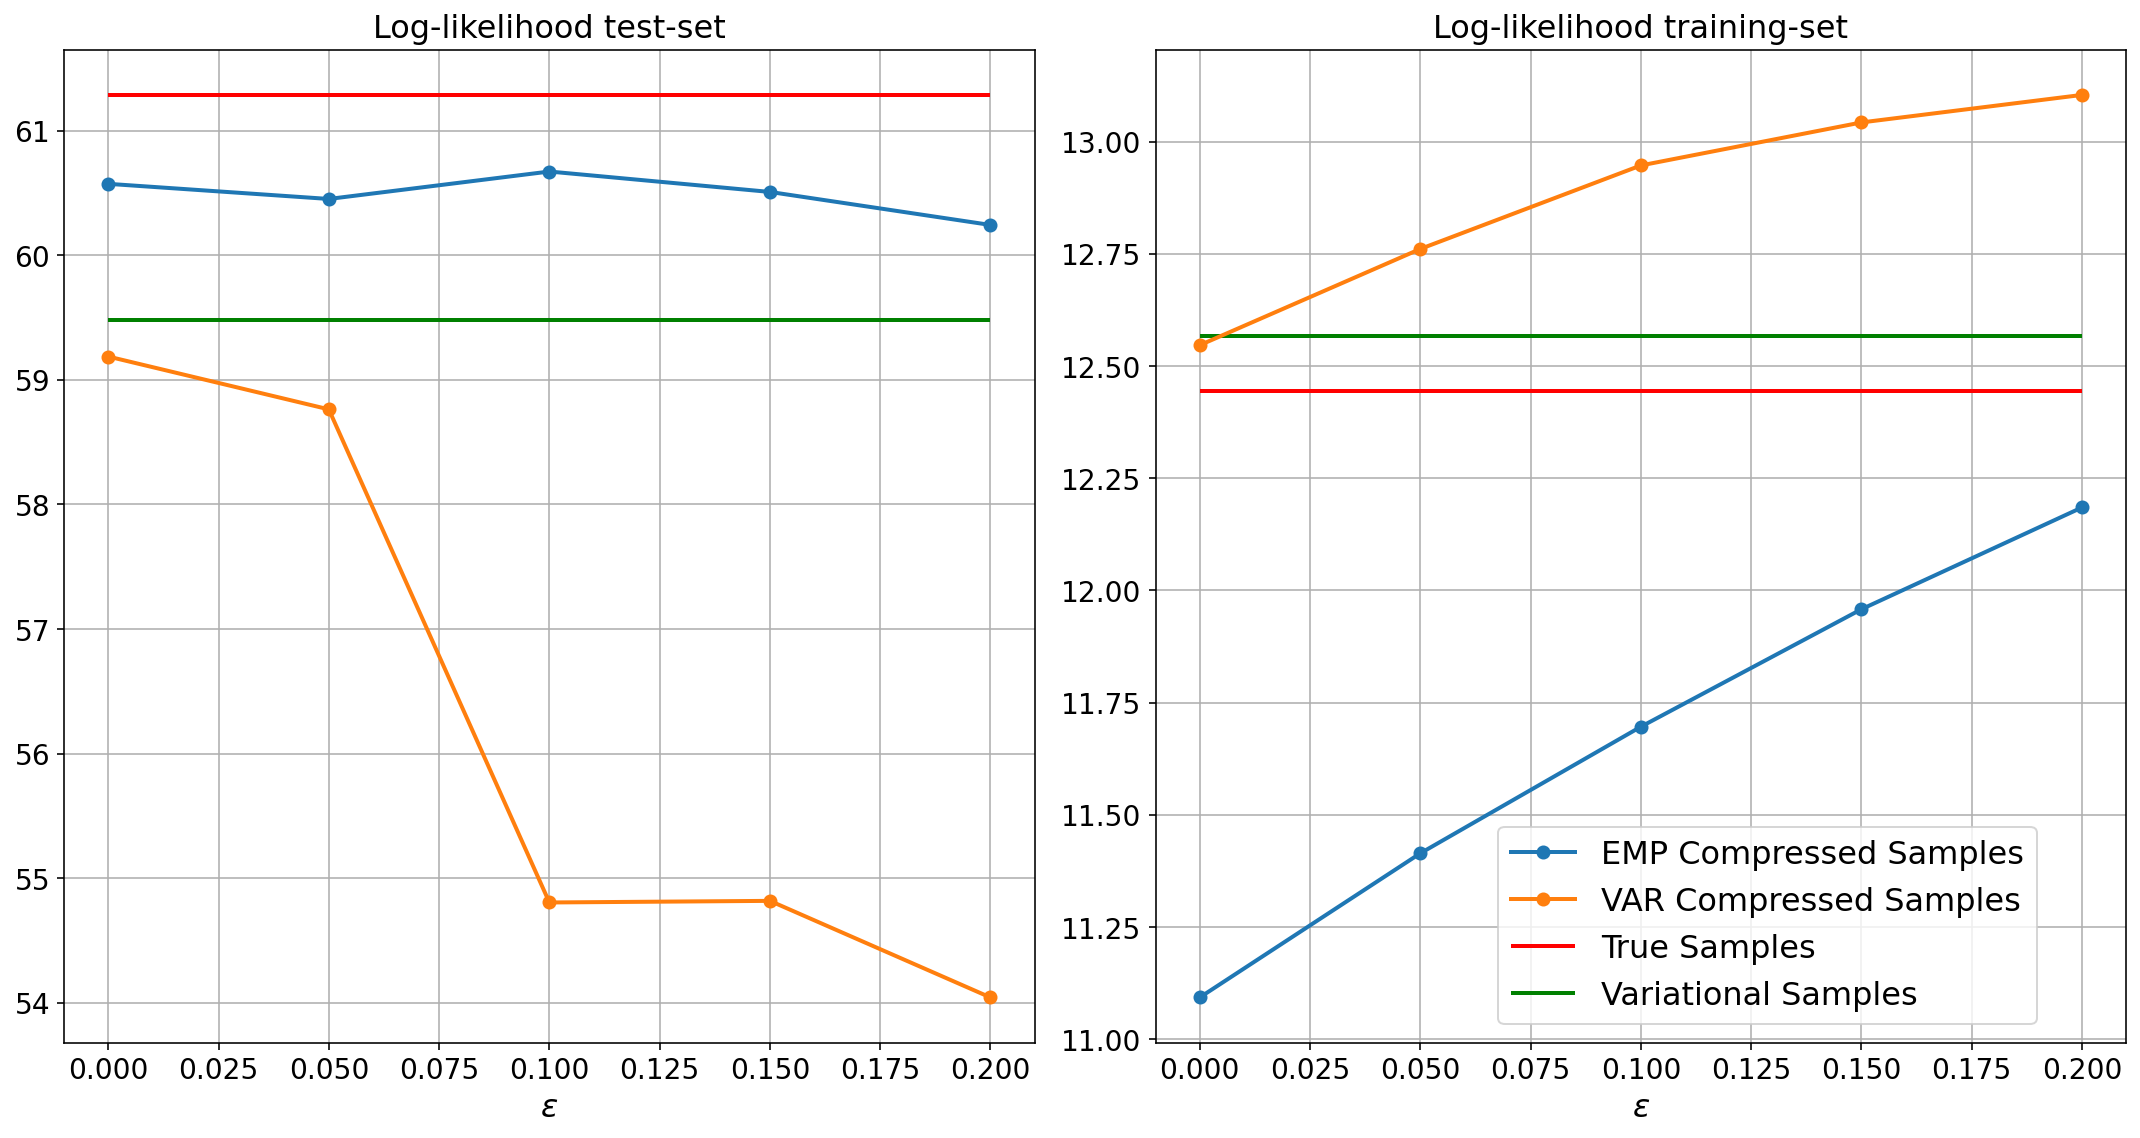

In [200]:
f, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=False)
ax[0].plot(epsilons, emp_log_probs, '-o', label='Empirical')
ax[0].plot(epsilons, var_log_probs, '-o', label='Variational')
ax[0].hlines(exact_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax[0].hlines(exact_var_log_probs, xmin=epsilons[0], xmax=epsilons[-1], color='green')
ax[0].grid()
ax[0].set_xlabel(r'$\epsilon$', fontsize=16)
ax[1].grid()
ax[1].set_xlabel(r'$\epsilon$', fontsize=16)
ax[0].set_title('Log-likelihood test-set', fontsize=16)
ax[1].set_title('Log-likelihood training-set', fontsize=16)
ax[1].plot(epsilons, emp_log_probs_train, '-o', label='Empirical')
ax[1].plot(epsilons, var_log_probs_train, '-o', label='Variational')
ax[1].hlines(exact_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax[1].hlines(exact_var_log_probs_train, xmin=epsilons[0], xmax=epsilons[-1], color='green')
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='minor', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
f.legend(['EMP Compressed Samples', 'VAR Compressed Samples', 'True Samples', 'Variational Samples'], loc = (0.7, 0.1), ncol=1, fontsize=16)
f.tight_layout()

In [234]:
def plot_preds(weights, b, ax=None, title='',
               plt_train_kwargs={'alpha' : 1, 'marker' :'*', 'color':'k', 'rasterized' : True},
               plt_test_kwargs={'alpha' : 0.5, 'marker' :'+', 'color':'k', 'rasterized' : True},
               plt_mean_kwargs={'color':'b', 'rasterized' : True},
               plt_true_kwargs={'color':'r', 'rasterized' : True},
               epistemic_kwargs={'alpha' : 0.5, 'rasterized' : True},
               aleatoric_kwargs={'alpha' : 0.2, 'rasterized' : True},
               fs=16,
               ):
    
    
    x_test = b.feature_targets_test
    y_test = b.regression_targets_test
    x_data = b.feature_targets_train
    y_data = b.regression_targets_train
    min_x = torch.min(b.feature_targets)
    max_x = torch.max(b.feature_targets)
    xs = torch.linspace(min_x, max_x, 100)
    ys = b.empirical_prediction(b.true_sample, feature_targets=xs.reshape(-1, 1))
    preds = compute_preds_from_samples(weights, b, xs=xs)
    if ax is None:
        ax = plt.gca()

    m = preds.mean(0).to('cpu')
    s = 1.96 * preds.std(0).to('cpu')
    s_al = 1.96 * (preds.var(0).to('cpu') + b.signal_std ** 2) ** 0.5

    # Get upper and lower confidence bounds
    lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
    # + aleotoric
    lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

    # Plot training data as black stars
    ax.scatter(x_data.numpy(), y_data.numpy(), **plt_train_kwargs, label='Train Data')
    # Plot testing data as black crosses
    ax.scatter(x_test.numpy(), y_test.numpy(), **plt_test_kwargs, label='Test Data')
    # Plot predictive means as blue line
    ax.plot(xs.numpy(), m.numpy(), **plt_mean_kwargs, label='Mean')
    ax.plot(xs.numpy(), ys.numpy(), **plt_true_kwargs, label='Ground Truth')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xs.flatten().numpy(), lower.numpy(), upper.numpy(), **epistemic_kwargs, label='Epistemic')
    ax.fill_between(xs.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), **aleatoric_kwargs, label = 'Aleatoric')
    #ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(title, fontsize=fs)
    ax.set_xlim(min_x, max_x)
    bbox = {'facecolor': 'white', 'alpha': 0.6, 'pad': 0.5, 'boxstyle': 'round', 'edgecolor':'black'}
#     ax.text(-5, 1.2, f'Test LL: {test_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
#     ax.text(-5, 0.05, f'Train LL: {train_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
    ax.grid()
    return(ax)

In [251]:
def plot_preds(weights, b, ax=None, title='',
               plt_train_kwargs={'alpha' : 1, 'marker' :'*', 'color':'k', 'rasterized' : True},
               plt_test_kwargs={'alpha' : 0.5, 'marker' :'+', 'color':'k', 'rasterized' : True},
               plt_sample_kwargs={'color':'gray', 'rasterized' : True, 'alpha' : 0.01},
               plt_true_kwargs={'color':'r', 'rasterized' : True},
               epistemic_kwargs={'alpha' : 0.5, 'rasterized' : True},
               aleatoric_kwargs={'alpha' : 0.2, 'rasterized' : True},
               fs=16,
               ):
    

    x_test = b.feature_targets_test
    y_test = b.regression_targets_test
    x_data = b.feature_targets_train
    y_data = b.regression_targets_train
    min_x = torch.min(b.feature_targets)
    max_x = torch.max(b.feature_targets)
    xs = torch.linspace(min_x, max_x, 100)
    ys = b.empirical_prediction(b.true_sample, feature_targets=xs.reshape(-1, 1))
    preds = compute_preds_from_samples(weights, b, xs=xs)
    if ax is None:
        ax = plt.gca()

    # Plot training data as black stars
    ax.scatter(x_data.numpy(), y_data.numpy(), **plt_train_kwargs, label='Train Data')
    # Plot testing data as black crosses
    ax.scatter(x_test.numpy(), y_test.numpy(), **plt_test_kwargs, label='Test Data')
    # Plot predictive means as blue line
    for p in preds:
        ax.plot(xs.numpy(), p, **plt_sample_kwargs, label='Mean')
    ax.plot(xs.numpy(), ys.numpy(), **plt_true_kwargs, label='Ground Truth')
    # Shade between the lower and upper confidence bounds
    #ax.legend(['Observed Data', 'Mean', 'Ground Truth', 'Epistemic', 'Aleatoric'], fontsize = fs)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_title(title, fontsize=fs)
    ax.set_xlim(min_x, max_x)
    bbox = {'facecolor': 'white', 'alpha': 0.6, 'pad': 0.5, 'boxstyle': 'round', 'edgecolor':'black'}
#     ax.text(-5, 1.2, f'Test LL: {test_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
#     ax.text(-5, 0.05, f'Train LL: {train_ll:.2f}', bbox=bbox, fontsize=fs, horizontalalignment='center')
    ax.grid()
    return(ax)

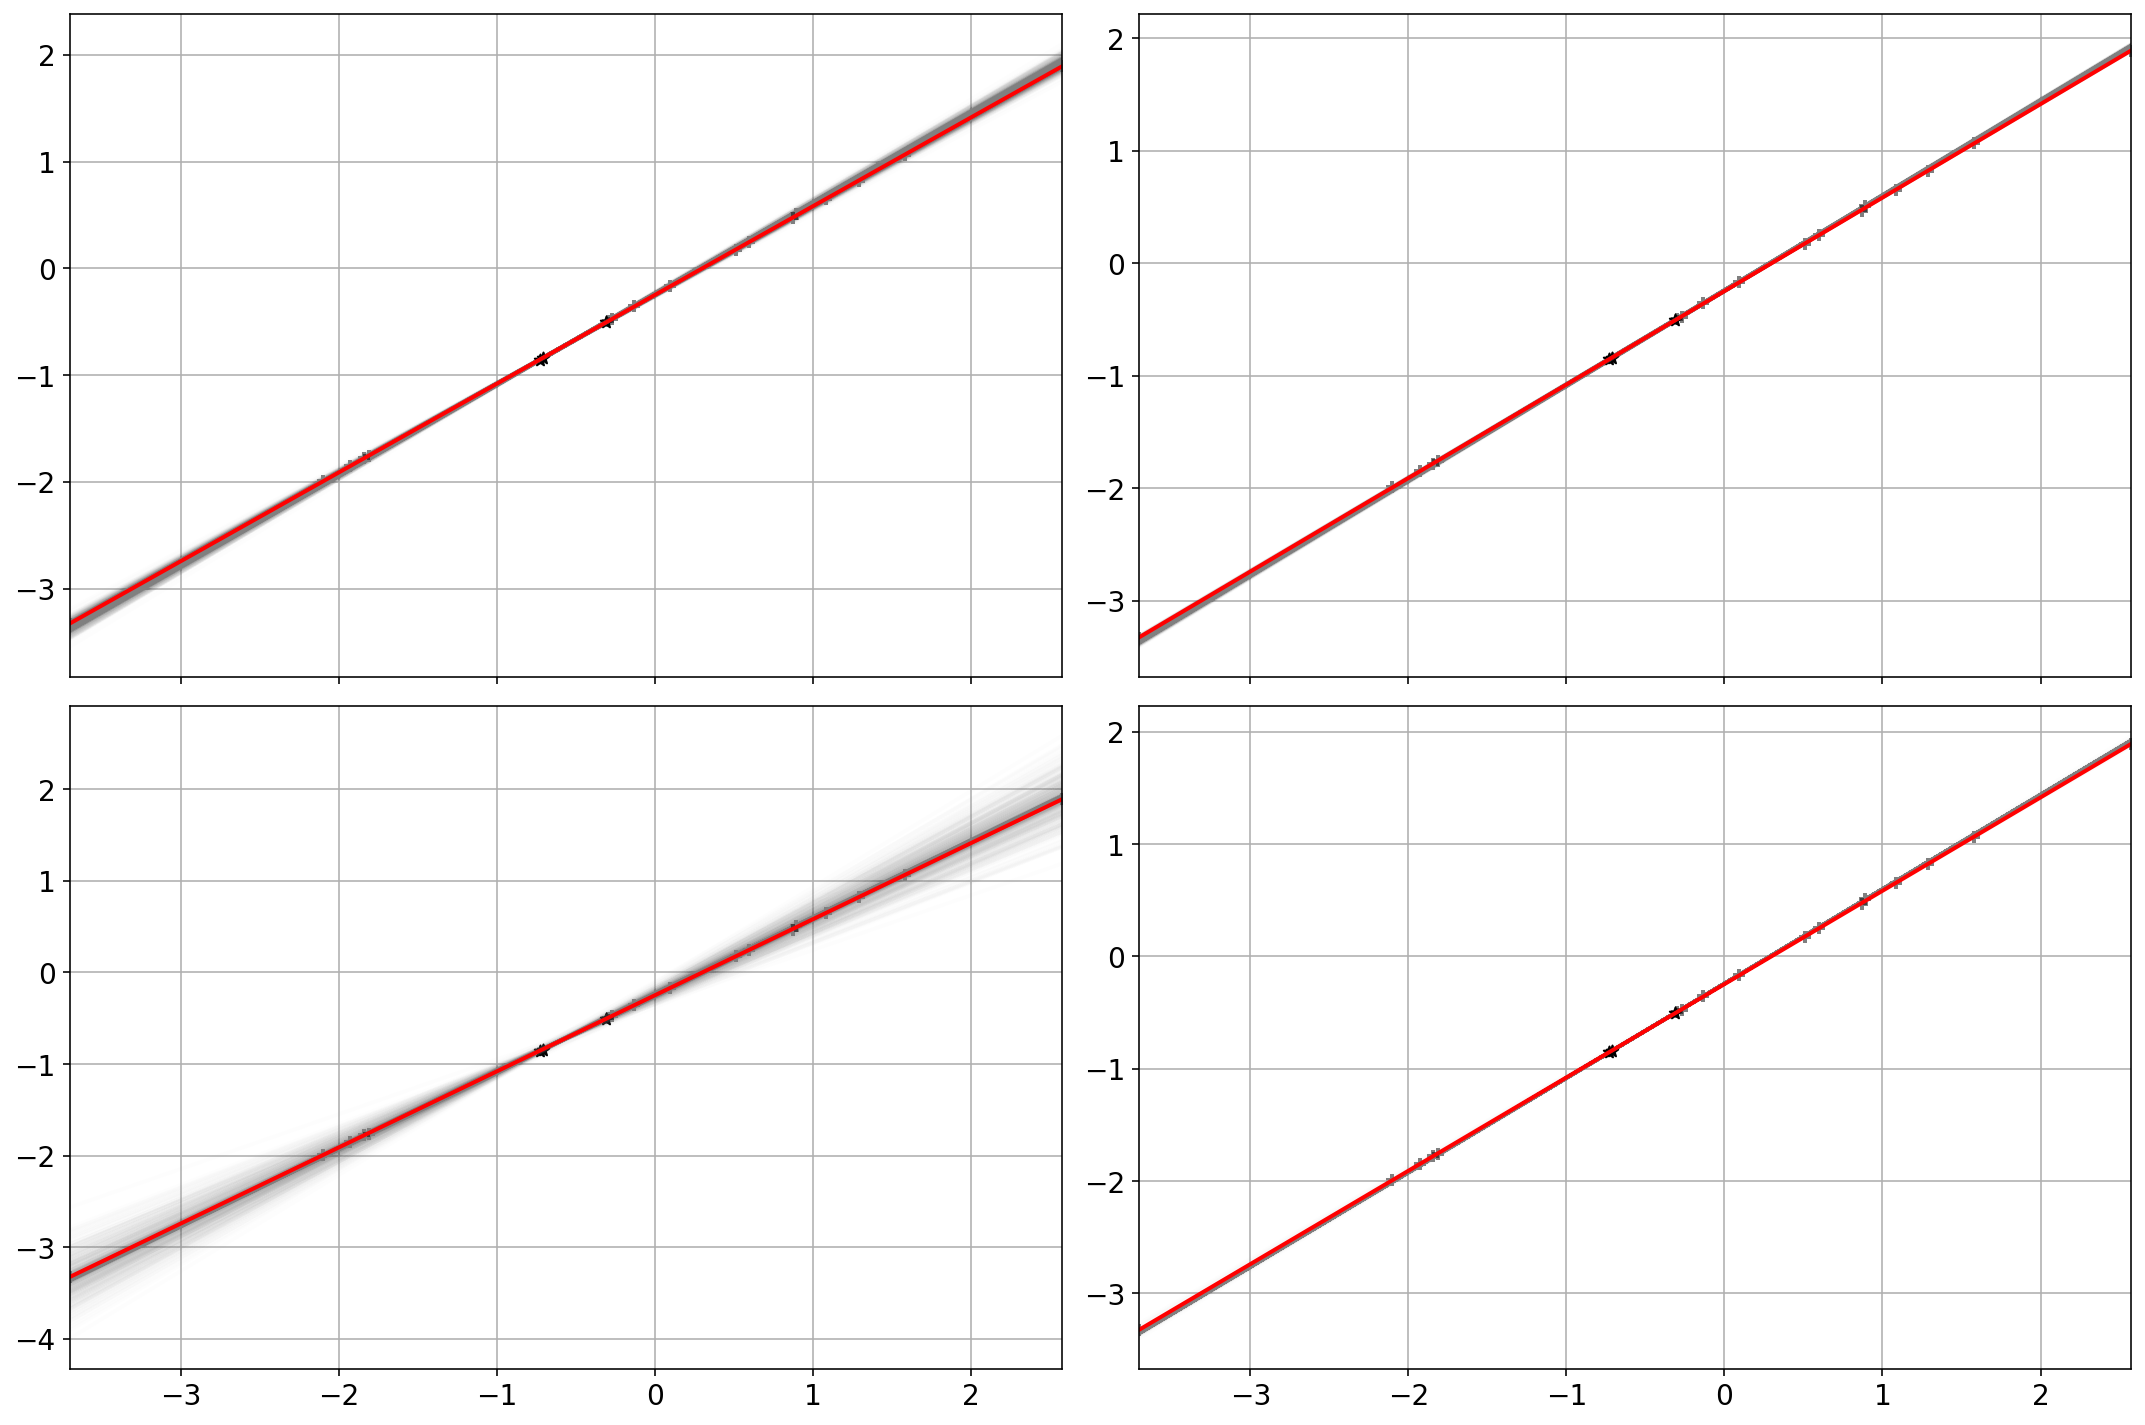

In [252]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
ax1[0] = plot_preds(b.weight_posterior.sample((500,)), b, ax=ax1[0])
ax1[1] = plot_preds(compute_variational_posterior(t).sample((500,)), b, ax=ax1[1])
ax2[0] = plot_preds(torch.tensor(emp[-1]['compressed_samples']), b, ax=ax2[0])
ax2[1] = plot_preds(torch.tensor(vari[-1]['compressed_samples']), b, ax=ax2[1])
f.tight_layout()